# NURBS
NURBS (Non-Uniform Rational B-Spline) curve is one of parametric curve, which is derived from Bezier curve and has weights for each control points and a knot vector. Bezier curve with weights (called Rational Bezier curve) has an ability to represent quadric curve, and Bezier curve with knot vector (called B-spline curve) has an property when one control points moved, whole curve is not changed, in short, localiity. In other words, Bezier curve can be said to be  special pattern of NURBS.

Here, I try to design the model of NURBS and display using matplotlib.

### Reference
[CG-ARTS コンピュータグラフィックス [改訂新版]](https://www.cgarts.or.jp/book/cg_engineer/index.html) pp. 76-92

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## B-spline basis function
B-spline basis function is used as the interpolation of control points. Besides the parameter $t$, it is composed of degree $d$ and knot vector $k$. The number of element of $\boldsymbol k$ is formulated as $d + n + 1$, $n$ denotes the number of control points. B-spline basis function $B_{i}^{j}(t)$ is written as:
$$
B_{i}^{0}(t) =
  \begin{cases}
    1 \quad k_i \leqq t \lt k_{i+1}  \\
    0 \quad else\\
  \end{cases} \\
B_{i}^{j}(t) = \frac{t - k_i}{k_{i+d} - k_i} B_{i}^{j-1}(t) + \frac{k_{i+d+1} - t}{k_{i+d+1} - k_{i+1}} B_{i+1}^{j-1}(t)
$$
Here, $i$ denotes the index of knot vector and $j$ denotes the degree. Below cell computes this function recursively.

In [ ]:
def b_spline_basis_func(t, index, degree, knot):
  if degree == 0:
    if knot[index] <= t and t < knot[index+1]:
      return 1
    else:
      return 0
  else:
    first = (t - knot[index]) / (knot[index+degree] - knot[index]) if knot[index+degree] != knot[index] else 0
    second = (knot[index+degree+1] - t) / (knot[index+degree+1] - knot[index+1]) if knot[index+degree+1] != knot[index+1] else 0

    return first * b_spline_basis_func(t, index, degree-1, knot) + second * b_spline_basis_func(t, index+1, degree-1, knot)

## 2-dimension NURBS curve
As I mentioned before, NURBS includes weights $\boldsymbol w$ for each control points $P$ . The coordinates on the curve $\boldsymbol C$ at parameter $t$ is formulated like this:
$$
\boldsymbol C(t) = \frac{\sum_{i = 0}^{n-1}w_i \boldsymbol P_i B_i^d(t)}{\sum_{i = 0}^{n-1}w_i B_i^d(t)}
$$
note that $t$ is defined in the range $t_d \leqq t \leqq t_{n}$.

In [ ]:
def nurbs_curve2(t, weights, knot, control_points):
  numerator = np.array([0.0, 0.0])
  for i in range(len(control_points)):
    wn = weights[i] * b_spline_basis_func(t, i, len(knot) - len(control_points) - 1, knot)
    numerator += control_points[i] * wn
  
  denomator = 0.0001
  for i in range(len(control_points)):
    wn = weights[i] * b_spline_basis_func(t, i, len(knot) - len(control_points) - 1, knot)
    denomator += wn

  return numerator / denomator

## draw the circle
When representing a circle using NURBS, degree $d = 2$ and knot vector $\boldsymbol k$ , control points $\boldsymbol P$ and weights $\boldsymbol w$ are given as below.

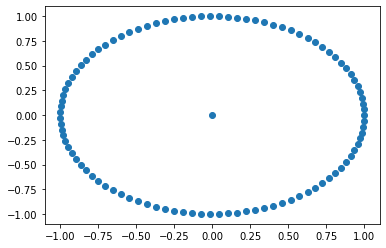

In [ ]:
# circle
knot = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4])
control_points = np.array([[1.0, 0.0], [1.0, 1.0], [0.0, 1.0], [-1.0, 1.0], [-1.0, 0.0], [-1.0, -1.0], [0.0, -1.0], [1.0, -1.0], [1.0, 0.0]])
weights = np.array([1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1])

t = np.linspace(0, 4, 100)
y = np.zeros((t.shape[0], 2))
for i in range(t.shape[0]):
  y[i] = nurbs_curve2(t[i], weights, knot, control_points)

# print(y)
plt.scatter(y[:, 0], y[:, 1])
plt.show()

## 3-dimension NURBS surface
When representing surface, elements of each component are prepared along to two directions, $u$ and $v$. $d \times e$ degree, $m \times n$ control points $P$ , weights $w$, two knot vector $\boldsymbol a = [a_i | i = 0, 1, ..., m + d + 1], \boldsymbol b = [b_j | j = 0, 1, ..., n + e + 1$] are given. The coordinates on the surface $\boldsymbol S$ at parameter $u, v$ is formulated like this:
$$
\boldsymbol S(u, v) = \frac{\sum_{i = 0}^{m-1} \sum_{j = 0}^{n-1} w_{ij} \boldsymbol P_{ij} B_i^d(u)B_j^e(v)}{\sum_{i = 0}^{m-1} \sum_{j = 0}^{n-1} w_{ij} B_i^d(u)B_j^e(v)}
$$
note that $u$ is defined in the range $u_d \leqq u \leqq u_{m}$ and $v$ is defined in the range $v_e \leqq v \leqq v_{n}$.

In [ ]:
def nurbs_surface(u, v, weights, u_knot, v_knot, control_points):
  numerator = np.array([0.0, 0.0, 0.0])
  denomator = 0.0001
  wn = np.zeros((control_points.shape[0], control_points.shape[1]))

  for i in range(control_points.shape[0]):
    for j in range(control_points.shape[1]):
      wn[i][j] = weights[i][j] * b_spline_basis_func(u, i, u_knot.shape[0] - control_points.shape[0] - 1, u_knot) \
        * b_spline_basis_func(v, j, v_knot.shape[0] - control_points.shape[1] - 1, v_knot)
      numerator += control_points[i][j] * wn[i][j]
  denomator += np.sum(wn)

  return numerator / denomator

## draw the surface
2d circle is exteneded to 3D. (more sophisticated method may be existed)

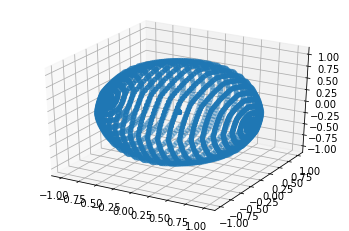

In [ ]:
# sphere
u_knot = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4])
v_knot = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4])
control_points3 = np.zeros((9, 9, 3))
a = np.array([[1.0, 0.0, 0.0], [1.0, 0.0, 1.0], [0.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 0.0], [-1.0, 0.0, -1.0], [0.0, 0.0, -1.0], [1.0, 0.0, -1.0], [1.0, 0.0, 0.0]])
R = np.zeros((9, 3, 3))
for i in range(9):
  R[i] = np.array([
      [1, 0, 0],
      [0, np.cos(np.pi * i / 8), -np.sin(np.pi * i / 8)],
      [0, np.sin(np.pi * i / 8), np.cos(np.pi * i / 8)]
  ])
for i in range(9):
  for j in range(9):
    control_points3[i][j] = np.dot(R[i], a[j])

weights3 = np.array([
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
    [1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1, np.sqrt(2)/2, 1],
])

u = np.linspace(0, 4, 50)
v = np.linspace(0, 4, 50)
z= np.zeros((u.shape[0], v.shape[0], 3))
for i in range(u.shape[0]):
  for j in range(v.shape[0]):
    z[i][j] = nurbs_surface(u[i], v[j], weights3, u_knot, v_knot, control_points3)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(z[:, :, 0], z[:, :, 1], z[:, :, 2])
plt.show()